In [1]:
import pandas as pd
import numpy as np
import scipy.stats as spstats
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from math import sqrt
from imblearn.over_sampling import SMOTE
import os

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB 
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import GridSearchCV # cross validation
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.metrics import accuracy_score, RocCurveDisplay, roc_curve
from sklearn.metrics import confusion_matrix # creates a confusion matrix
from sklearn.metrics import plot_confusion_matrix # draws a confusion matrix
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.utils import class_weight

import seaborn as sns
import joblib
import sklearn.utils
from matplotlib import pyplot as plt
import xgboost as xgb



In [2]:
X_test = pd.read_csv('X_test.csv')
X_train = pd.read_csv('X_train.csv')
y_train = pd.read_csv('y_train.csv')
y_test = pd.read_csv('y_test.csv')

In [3]:
X_train.shape

(51350, 34)

In [4]:
def model_save(model):
    cwd = os.getcwd()
    new_dir = os.path.join(cwd, 'model')
    os.makedirs(new_dir, exist_ok=True)
    save_file = os.path.join(new_dir, f'{model}.pkl')

    pickle.dump(model, open(save_file, 'wb'))

In [5]:
def model_load(filename):
    cwd=os.getcwd()
    loaded_model = pickle.load(open((os.path.join(cwd,'model', filename)), 'rb'))
    return loaded_model

In [6]:
# function to run the model after fit and save relavent information into the dictionary
all_results = {}
def result_report(model, modelname, iteration, X_train = X_train, X_test = X_test):
    
    #running all the models
    train_result = model.predict(X_train)
    test_result = model.predict(X_test)
    test_result_prob = model.predict_proba(X_test)
    train_result_prob = model.predict_proba(X_train)

    #generating overall metrics
    report_train = classification_report(y_train, train_result, output_dict=True)
    report_test = classification_report(y_test, test_result, output_dict=True)

    #generating auc
    auc = metrics.roc_auc_score(y_test, test_result_prob[:,1])
    auc_train = metrics.roc_auc_score(y_train, train_result_prob[:,1])

    #saving the metrics
    dict_var = {}
    dict_var['train'] = report_train
    dict_var['test'] = report_test
    dict_var['test']['auc'] = auc
    dict_var['train']['cm'] = confusion_matrix(y_train, train_result)
    dict_var['test']['cm'] = confusion_matrix(y_test, test_result)

    all_results[f'{modelname}-{iteration}'] = dict_var

    #print auc
    return print('train:', auc_train, 'test:', auc)

### Random Forest

In [7]:
rf = RandomForestClassifier(random_state = 77, class_weight='balanced')
rf.fit(X_train, y_train.values.ravel())

RandomForestClassifier(class_weight='balanced', random_state=77)

In [8]:
result_report(rf, 'rf', 1)

train: 0.999991457611611 test: 0.8975376899370009


Due to overfit, let's consider modifying the following parameters:
- min_samples_split : default 2 
    - With default 2, trees continuing splitting even with 2 observations, resulting in bigger trees that might overfit
- max_depth : default None
    - Related to above, trees are allowed to grow until leaves are pure
- max_leaf_nodes : default None
    - leave as it is?
- min_samples_leaf : default 
    - similar to min_samples_split as it controls generating new splits
- max_features : default = auto
- max_samples : default = None


#### 2nd Iteration

In [9]:
rf2 = RandomForestClassifier(   random_state = 77, class_weight='balanced',
                                n_estimators = 75,
                                min_samples_split = 20,
                                max_samples = 0.5
                                )
rf2.fit(X_train, y_train.values.ravel())

RandomForestClassifier(class_weight='balanced', max_samples=0.5,
                       min_samples_split=20, n_estimators=75, random_state=77)

In [10]:
result_report(rf2, 'rf', 2)

train: 0.976785474567659 test: 0.9060336259589807


In [11]:
# param_dict_rf = {   #'random_state'      : 77,
#                     'n_estimators'      : [25, 50, 75, 100],
#                     'min_samples_split' : [10, 20, 30],
#                     'max_depth'         : [5, 6, 7, 8],
#                     'max_samples'       : [0.2, 0.5, 0.75]
#                 }

In [12]:
# grid_model_rf = GridSearchCV(   param_grid = param_dict_rf,
#                                 estimator = rf2,
#                                 cv = 5,
#                                 verbose = 1
#                             )

In [13]:
# grid_model_rf.fit(X_train, y_train.values.ravel())
# grid_model_rf.best_params_


NameError: name 'grid_model_rf' is not defined

#### 3rd Iteration

In [14]:
rf3 = RandomForestClassifier(   random_state = 77, class_weight='balanced',
                                n_estimators = 100,
                                min_samples_split = 30,
                                max_depth = 8,
                                max_samples = 0.75
                                )
rf3.fit(X_train, y_train.values.ravel())

RandomForestClassifier(class_weight='balanced', max_depth=8, max_samples=0.75,
                       min_samples_split=30, random_state=77)

In [15]:
result_report(rf3, 'rf', 3)

train: 0.9084177182004864 test: 0.8995879594115997


In [16]:
df_feature_rf = pd.DataFrame( {'feature' : X_train.columns, 'importance' : rf3.feature_importances_ })

In [17]:
#ranking features by importance to the model
df_feature_rf.sort_values(by='importance')

,feature,importance
15,institution_GB005,0.000107
11,institution_AU004,0.000194
17,institution_GB008,0.000212
19,adm_appl_method_HRD,0.000293
13,institution_GB002,0.000313
20,adm_appl_method_PPG,0.000709
27,appl_first_citizenship_P,0.001049
32,race_code_OTHERS,0.001058
26,appl_first_nationality_OTHR,0.001059
31,race_code_MALAY,0.001118


#### 4th Iteration

Let's try dropping features the lowest 10 features.

In [18]:
feature_list_to_drop = df_feature_rf.sort_values(by='importance')['feature'][0:10].tolist()

In [19]:

X_train_1 = X_train.drop(feature_list_to_drop, axis=1)
X_test_1 = X_test.drop(feature_list_to_drop, axis=1)


In [20]:
rf4 = RandomForestClassifier(   random_state = 77, class_weight='balanced',
                                n_estimators = 75,
                                min_samples_split = 30,
                                max_depth = 8,
                                max_samples = 0.5
                                )
rf4.fit(X_train_1, y_train.values.ravel())


RandomForestClassifier(class_weight='balanced', max_depth=8, max_samples=0.5,
                       min_samples_split=30, n_estimators=75, random_state=77)

In [21]:
result_report(rf4, 'rf', 4, X_train=X_train_1, X_test=X_test_1)

train: 0.9072992222596113 test: 0.8996179400945212


In [22]:
all_results['rf-4']['test']['cm']

array([[12619,   156],
       [ 1156,  3186]], dtype=int64)

#### 5th Iteration

In [23]:
# param_dict_rf2 = {   #'random_state'      : 77,
#                     'n_estimators'      : [50, 75, 100],
#                     'max_depth'         : [6, 8, 10],
#                     'min_samples_split' : [5, 10, 20, 30],
#                     'max_samples'       : [0.2, 0.5, 0.75]
#                 }
# grid_model_rf2 = GridSearchCV(   param_grid = param_dict_rf,
#                                 estimator = rf2,
#                                 cv = 5,
#                                 verbose = 1
#                             )
# grid_model_rf.fit(X_train_1, y_train.values.ravel())
# grid_model_rf.best_params_

In [24]:
rf5 = RandomForestClassifier(   random_state = 77, class_weight='balanced',
                                n_estimators = 75,
                                max_depth = 8,
                                min_samples_split = 30,
                                max_samples = 0.5
                                )
rf5.fit(X_train_1, y_train.values.ravel())

RandomForestClassifier(class_weight='balanced', max_depth=8, max_samples=0.5,
                       min_samples_split=30, n_estimators=75, random_state=77)

In [25]:
result_report(rf5, 'rf', 5, X_train = X_train_1, X_test = X_test_1)

train: 0.9072992222596113 test: 0.8996179400945212


### Model - XGBOOST

#### 1st Iteration

In [26]:
classes_weights = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=y_train['label']
)

In [27]:
# First Iteration
xg = xgb.XGBClassifier(objective='binary:logistic',
                            eval_metric='auc', 
                            random_state = 24)
xg.fit(X_train, y_train, sample_weight=classes_weights)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=24,
              reg_alpha=0, reg_lambda=1, ...)

In [28]:
result_report(xg, 'xgb', 1)


train: 0.9640914583760987 test: 0.9005921229947151


We see the model here is overfitting to the training data. We need to reduce complexity. Let's try:
- reducing the max_depth parameter from the default of 6
- increasing the gamma from the default of 0
- subsampling

#### 2nd Iteration

In [32]:
xg2 = xgb.XGBClassifier(objective='binary:logistic', 
                            eval_metric='auc', 
                            random_state = 24,
                            
                            max_depth = 3,
                            gamma = 0.5,
                            subsample = 0.35,
                            scale_pos_weight = 2)
xg2.fit(X_train, y_train, sample_weight=classes_weights)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', gamma=0.5, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=24,
              reg_alpha=0, reg_lambda=1, ...)

In [33]:
result_report(xg2, 'xgb', 2)

train: 0.9251417373355646 test: 0.905471005903292


#### 3rd Iteration

In [42]:
#ROUND 1: First set of parameters ------------------
param_grid_xg = {
    'max_depth': [4, 5],
    'eta': [0.1, 0.2],
    'min_child_weight' : [1, 2],
    'lambda' : [1,2],
    'gamma': [0.2, 0.5],
    'scale_pos_weight': [1, 1.5],
    
    'subsample' : [0.8],
    'colsample_bytree' : [0.8]
    
}

grid_model_xg = GridSearchCV(param_grid= param_grid_xg, 
                             estimator= xg2,
                             scoring='roc_auc',
                             cv= 4, 
                             verbose=1)

grid_model_xg.fit(X_train, y_train)

grid_model_xg.best_params_

Fitting 4 folds for each of 64 candidates, totalling 256 fits


{'colsample_bytree': 0.8,
 'eta': 0.1,
 'gamma': 0.2,
 'lambda': 1,
 'max_depth': 4,
 'min_child_weight': 2,
 'scale_pos_weight': 1,
 'subsample': 0.8}

{'gamma': 1.0, 'learning_rate': 0.1, 'max_depth': 6, 'scale_pos_weight': 1}
{'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'scale_pos_weight': 4}
{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'scale_pos_weight': 1}


In [35]:
xg3 = xgb.XGBClassifier(    objective='binary:logistic', 
                            eval_metric='auc', 
                            random_state = 24,
                            
                            colsample_bytree = 0.8,
                            eta = 0.1,
                            gamma = 0.2,
                            reg_lambda = 1,
                            max_depth = 5,
                            min_child_weight = 1,
                            scale_pos_weight = 1,
                            subsample = 0.8
                        )
xg3.fit(X_train, y_train, sample_weight=classes_weights)



XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
              early_stopping_rounds=None, enable_categorical=False, eta=0.1,
              eval_metric='auc', gamma=0.2, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.100000001, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=24,
              reg_alpha=0, ...)

In [36]:
result_report(xg3, 'xgb', 3)

train: 0.9329391158656866 test: 0.9079306838678507


### Compare Results

In [37]:
model = []
precision = []
recall = []
auc = []
accuracy = []
for k in all_results.keys():
    model.append(k)
    precision.append(all_results[k]['test']['1']['precision'])
    recall.append(all_results[k]['test']['1']['recall'])
    auc.append(all_results[k]['test']['auc'])
    accuracy.append(all_results[k]['test']['accuracy'])

In [38]:
d = {   'model': model,
        'precision': precision,
        'recall' : recall,
        'accuracy' : accuracy,
        'auc' : auc
        }
df_result = pd.DataFrame(d)
df_result.sort_values(by='model')

,model,precision,recall,accuracy,auc
0,rf-1,0.965517,0.735145,0.926155,0.897538
1,rf-2,0.968494,0.736297,0.927032,0.906034
2,rf-3,0.921647,0.742285,0.918619,0.899588
3,rf-4,0.953321,0.733763,0.923351,0.899618
4,rf-5,0.953321,0.733763,0.923351,0.899618
5,xgb-1,0.924134,0.743436,0.919437,0.900592
6,xgb-2,0.707541,0.797328,0.864988,0.905471
7,xgb-3,0.971655,0.734224,0.927148,0.907931


Text(33.0, 0.5, 'True Values')

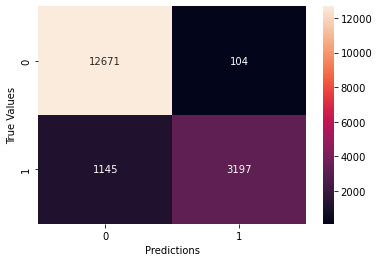

In [39]:
rf_p = sns.heatmap(all_results['rf-2']['test']['cm'], annot=True, fmt='d')
rf_p.set_xlabel("Predictions")
rf_p.set_ylabel("True Values")

In [40]:
def cm_heatmap(array):
    perc = (array.T/np.sum(array)).T
    cm = sns.heatmap(perc, annot=True, fmt='.1%')
    return cm

Text(33.0, 0.5, 'True Values')

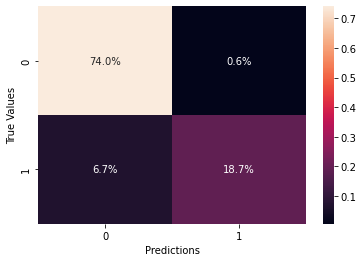

In [41]:
rf2_cm = cm_heatmap(all_results['rf-2']['test']['cm'])
rf2_cm.set_xlabel("Predictions")
rf2_cm.set_ylabel("True Values")

1 = don't accept offer > intervene
0 = accept offer

true negative   //    false positive
false negative  //    true positive